In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from model import PIC
import cv2
from utils import read_config
import dataset
import os

# Prepare data

In [2]:
cfg = read_config('configs/base_config.yaml')

In [3]:
if cfg.DATASET == 'ImageNet_noise_reduction':
    train_dataset = dataset.ImageNet_noise_reduction(cfg)
    train_dataloader = DataLoader(dataset=train_dataset, batch_size=cfg.BATCH_SIZE, shuffle=True, num_workers=8)

    val_dataset = dataset.ImageNet_noise_reduction(cfg, 'Val')
    val_dataloader = DataLoader(dataset=val_dataset, batch_size=1, shuffle=True, num_workers=8)
    
print('Train dataset length: ', len(train_dataset))
print('Val dataset length: ', len(val_dataset))

Train dataset length:  38657
Val dataset length:  6500


# Prepare net

In [4]:
from model import Model
net = Model(cfg)
net.to(torch.device(net.cfg.DEVICE))

Model(
  (conv_inp): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (sr_block): SR_Block(
    (sender): Sender(
      (conv): ConvTranspose2d(32, 64, kernel_size=(3, 3), stride=(3, 3))
    )
    (receiver): Receiver(
      (conv): Conv2d(64, 32, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1), dilation=(2, 2))
    )
    (activation): ReLU()
  )
  (conv_out): Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

# Train

In [5]:
from train import train_val_loop

In [6]:
train_val_loop(net, train_dataloader)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: p-k-babkin (p-k-babkin-rsm). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/petr/.netrc


Training epoch [1/2] ...


100%|██████████| 3866/3866 [12:50<00:00,  5.02it/s]


Epoch [1/2] training finshed, loss =  0.42537227272987366


100%|██████████| 3866/3866 [05:53<00:00, 10.94it/s]


Epoch [1/2] validation finshed.
Training epoch [2/2] ...


100%|██████████| 3866/3866 [12:41<00:00,  5.08it/s]


Epoch [2/2] training finshed, loss =  0.22474980354309082


100%|██████████| 3866/3866 [05:53<00:00, 10.95it/s]


Epoch [2/2] validation finshed.


Train/MSE Block 0,█▃▃▃▃▃▃▃▃▂▄▂▂▃▃▂▂▁▁▂▁▂▂▁▃▃▂▂▂▂▃▂▃▂▂▁▂▄▂▂
Train/MSE Block 1,█▄▃▃▃▃▃▃▃▂▄▂▂▃▃▂▁▁▁▁▁▂▂▁▃▂▂▂▂▂▃▂▃▂▂▁▂▃▂▂
Train/MSE Block 2,█▄▃▂▃▂▃▂▂▂▃▂▂▃▂▂▁▁▁▁▁▂▂▁▂▂▂▂▂▂▂▁▂▁▂▁▂▃▂▁
Train/MSE Block 3,█▄▃▂▃▂▃▂▂▂▃▂▂▂▂▂▁▁▁▁▁▁▂▁▂▂▂▁▂▂▂▁▂▁▂▁▂▃▂▁
Train/MSE Block 4,█▃▃▂▂▂▃▂▂▂▃▂▂▂▂▂▁▁▁▁▁▁▂▁▂▂▂▁▂▂▂▁▂▁▂▁▂▂▁▁
Train/Total Loss,█▄▃▂▃▂▃▂▂▂▃▂▂▃▂▂▁▁▁▁▁▂▂▁▂▂▂▂▂▂▃▁▂▁▂▁▂▃▂▁
Val/ImMSE Block 0,▆▄▇▅▃█▅▇▆▆▄▂▄▃▃▅▅▆▃▅▃▂▆▇▆▁▃▅▇▆▂▄▆▅▃▆▃▃▃▅
Val/ImMSE Block 1,▆▅▇▅▃█▆▇▆▆▅▂▄▃▄▅▅▆▄▅▃▂▆▇▆▁▃▅▇▆▃▄▆▅▃▆▄▃▄▅
Val/ImMSE Block 2,▇▅▇▅▄█▆▇▆▇▅▃▅▃▄▅▅▇▄▅▃▂▆▇▇▁▃▅▇▆▃▄▆▅▃▆▄▄▄▅
Val/ImMSE Block 3,▇▅▇▅▄█▇▇▇▇▅▂▅▃▄▆▆▇▅▅▃▂▆▇▇▁▃▅▇▇▄▄▆▅▃▇▄▄▄▅
Val/ImMSE Block 4,▇▅▇▅▄█▇▇▇▇▆▂▅▃▄▆▆▇▅▅▂▂▆▇▇▁▃▅▇▇▄▄▆▅▃▇▄▄▄▅


# Look at results

In [7]:
from utils import reconstruct_im
import matplotlib.pyplot as plt

In [22]:
sample = train_dataset[0]
test_inp = {
    'im_orig' : torch.tensor(sample['im_orig']).to(torch.float).unsqueeze(0),
    'im_noisy' : torch.tensor(sample['im_noisy']).to(torch.float).unsqueeze(0),
}

net.eval()
net.cpu()
res = net(test_inp)

Text(0.5, 1.0, 'Pred')

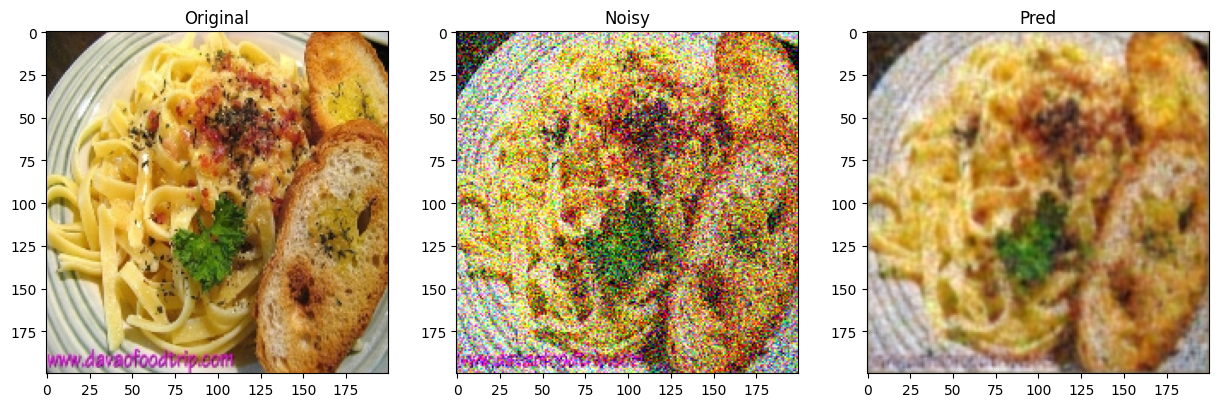

In [24]:
reconstructed_im_orig = reconstruct_im(res['im_orig'][0], cfg)
reconstructed_im_noisy = reconstruct_im(res['im_noisy'][0], cfg)
reconstructed_im_pred = reconstruct_im(res['outputs'][-1][0], cfg)

reconstructed_im_orig = cv2.cvtColor(reconstructed_im_orig, cv2.COLOR_BGR2RGB)
reconstructed_im_noisy = cv2.cvtColor(reconstructed_im_noisy, cv2.COLOR_BGR2RGB)
reconstructed_im_pred = cv2.cvtColor(reconstructed_im_pred, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Рисуем первую картинку
axes[0].imshow(reconstructed_im_orig, cmap='viridis')
axes[0].set_title('Original')

# Рисуем вторую картинку
axes[1].imshow(reconstructed_im_noisy, cmap='viridis')
axes[1].set_title('Noisy')

# Рисуем третью картинку
axes[2].imshow(reconstructed_im_pred, cmap='viridis')
axes[2].set_title('Pred')

In [25]:
import metrics as m
metrics_list = m.create_metrcs_list(cfg)

m.get_metrics_dict(metrics_list, res)

{'ImMSE Block 0': 86.82460833333333,
 'PSNR Block 0': 28.744375279873935,
 'SSIM Block 0': 0.6359364813121862,
 'ImMSE Block 1': 87.08405833333333,
 'PSNR Block 1': 28.73141700826104,
 'SSIM Block 1': 0.6406234672784908,
 'ImMSE Block 2': 86.93495833333333,
 'PSNR Block 2': 28.738859105606203,
 'SSIM Block 2': 0.6356973870269127,
 'ImMSE Block 3': 87.36129166666667,
 'PSNR Block 3': 28.71761314266878,
 'SSIM Block 3': 0.6299394094891433,
 'ImMSE Block 4': 87.55965,
 'PSNR Block 4': 28.70776343963022,
 'SSIM Block 4': 0.6229420243653875}